# Imports

In [41]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

from keras.utils import to_categorical
from keras.layers import Dense, Activation, Conv2D,Conv2DTranspose, Dropout, Reshape, MaxPooling2D, Flatten, LeakyReLU, BatchNormalization
from keras.models import Sequential, load_model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam


from sklearn.model_selection import train_test_split

# Parameters

In [42]:
N_EPOCHS = 800
BATCH_SIZE = 16
DATASET_SIZE = 292
TRAIN_DATA_SIZE = 96
LATENT_DIM = 128

# Data importing and pre-processing

In [43]:
df = pd.read_csv('dataset.csv', header=None)


df = df.values.reshape(DATASET_SIZE, 64, 64, 1)

x_real_train, x_real_test = train_test_split(df, test_size=0.2)


normalize dataset data into range of sigmoid [0,1], and put into batches

In [44]:
x_real_train = x_real_train.astype('float32')
x_real_train /=255


training_data = tf.data.Dataset.from_tensor_slices(x_real_train).shuffle(TRAIN_DATA_SIZE).batch(BATCH_SIZE)

Visualise example from dataset

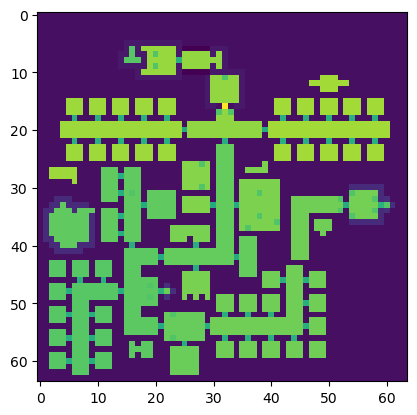

In [45]:
plt.imshow(df[0])

# Generator Model

Create points in latent space to be fed into generator

In [46]:
def generate_generator_input(no_of_maps):
    input = tf.random.normal(shape=(no_of_maps, LATENT_DIM))
    
    return input

In [47]:
def make_generator():
    model = Sequential()
    
    model.add(Dense(LATENT_DIM*8*8, input_shape=(LATENT_DIM,)))

    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8,8,LATENT_DIM)))


    
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(8,8,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(16,16,60)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    


    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False, input_shape=(32,32,60)))
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=5, padding="same"))
    model.add(Activation("sigmoid"))
    
              
    model.summary()
    
    return model
    
    

# Discriminator Model

In [48]:

def make_discriminator():
    
    # 1st set of layers
    model = Sequential()
    model.add(Conv2D(16, kernel_size=4, strides=2, padding="same", input_shape=(64,64,1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    

    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    
    '''
    model.add(Conv2D(16, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    #model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    '''
    
    model.add(Dense(100, activation='relu'))
    #model.add(Activation='relu')
    
    # output layer
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(1)) # Binary classification (2 outputs), so only 1 dense layer needed
    model.add(Activation('sigmoid'))
    
    model.summary()
    return model
    

Create the models from the functions

In [49]:
gen_model = make_generator()

disc_model = make_discriminator()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 batch_normalization_8 (Bat  (None, 8192)              32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 16, 16, 64)        131072    
 Transpose)                                                      
                                                                 
 batch_normalization_9 (Bat  (None, 16, 16, 64)       

Next, test the untrained discriminator on the map of noise generated before

Negative values means fake, positive means real

## Loss and Optimizers

In [50]:
cross_entropy = BinaryCrossentropy(from_logits=True)



Discriminator loss, taken from: https://www.tensorflow.org/tutorials/generative/dcgan

In [51]:
def discrim_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

In [52]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [53]:
gen_optimizer = Adam(learning_rate =0.0001, beta_1=0.5)
disc_optimizer = Adam(learning_rate =0.0001, beta_1=0.5)

Discriminator accuracy

In [54]:
def compute_discrim_accuracy(real_output, fake_output):
    if real_output[0] >=0:
        
        if fake_output[0] <0:
            accuracy = (real_output[0] + fake_output[0]) / (real_output[0] + fake_output[0])
        else:
            accuracy = real_output[0]/ (real_output[0] + fake_output[0])
    elif fake_output[0] <0:
        accuracy = fake_output[0] / (real_output[0] + fake_output[0])
    else:
        accuracy = 0/ (real_output[0] + fake_output[0])
    
    return accuracy

## Training

Training step

In [55]:
@tf.function
def training_step(current_batch):
    
    noise_sample = generate_generator_input(BATCH_SIZE)
    

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generated_map = gen_model(noise_sample, training=True)
        print("generated map shape" + str(generated_map.shape))
        
        fake_output = disc_model(generated_map,  training=True)
        real_output = disc_model(current_batch, training=True)
        

        gen_loss = generator_loss(fake_output=fake_output)
        disc_loss = discrim_loss(real_output=real_output, fake_output=fake_output)

        disc_accuracy = compute_discrim_accuracy(real_output, fake_output)

        

    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

    return gen_loss, disc_loss, disc_accuracy

Train models

In [56]:
def train(dataset, N_EPOCHS):

    gen_losses = []
    disc_losses = []

    disc_accuracies = []
    
    img_seed = generate_generator_input(1)

    for epoch in range(N_EPOCHS):
        gen_losses_for_epoch = []
        disc_losses_for_epoch = []

        disc_accuracies_for_epoch = []

        print("epoch = " + str(epoch))

        for map_batch in dataset:
            
            
            gen_loss, disc_loss, disc_accuracy = training_step(map_batch)

            gen_losses_for_epoch.append(gen_loss)
            disc_losses_for_epoch.append(disc_loss)
            disc_accuracies.append(disc_accuracy)
        
        avg_gen_loss = sum(gen_losses_for_epoch) / TRAIN_DATA_SIZE
        avg_disc_loss = sum(disc_losses_for_epoch) / TRAIN_DATA_SIZE

        avg_disc_accuracy = sum(disc_accuracies_for_epoch) / TRAIN_DATA_SIZE

        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        disc_accuracies.append(avg_disc_accuracy)

        print("Gen loss = " + str(avg_gen_loss))
        print("Disc loss = " + str(avg_disc_loss))

        print("Disc accuracy = " + str(avg_disc_accuracy))
# generate and show a map after 10 epochs

        if epoch % 10 == 0:
            
            generated_map = gen_model(img_seed, training=False)
            generated_map *= 255
            generated_map = generated_map.numpy()
            generated_map.reshape(64,64)
            generated_map = np.round(generated_map,0)
            generated_map = generated_map.tolist()
            plt.imshow(generated_map[0])
            plt.show()
    
    input_for_map_after_training = generate_generator_input(1)
    generated_map = gen_model(input_for_map_after_training, training=False)

    

    return gen_losses, disc_losses, generated_map, disc_accuracies


Train GAN

epoch = 0
generated map shape(16, 64, 64, 1)


/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


generated map shape(16, 64, 64, 1)
generated map shape(16, 64, 64, 1)
Gen loss = tf.Tensor(0.09756189, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21339291, shape=(), dtype=float32)
Disc accuracy = 0.0


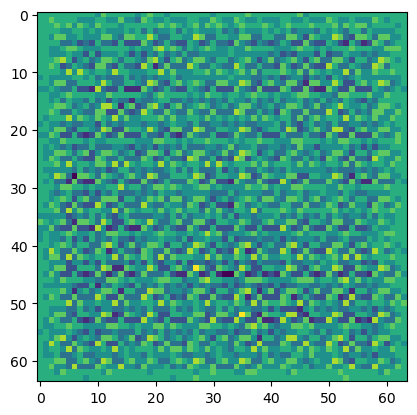

epoch = 1
Gen loss = tf.Tensor(0.12060454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19777007, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 2
Gen loss = tf.Tensor(0.11583999, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19012852, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 3
Gen loss = tf.Tensor(0.10418271, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20287775, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 4
Gen loss = tf.Tensor(0.14206715, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16002943, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 5
Gen loss = tf.Tensor(0.12591834, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16100168, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 6
Gen loss = tf.Tensor(0.11712685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19182754, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 7
Gen loss = tf.Tensor(0.10661898, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22472584, shape=(), dtype=

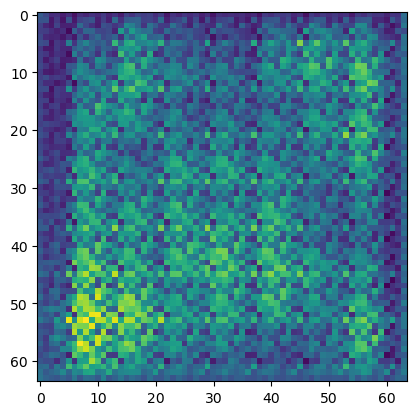

epoch = 11
Gen loss = tf.Tensor(0.12822457, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18996608, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 12
Gen loss = tf.Tensor(0.106217064, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24429579, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 13
Gen loss = tf.Tensor(0.07577939, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.3145316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 14
Gen loss = tf.Tensor(0.11026049, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2181151, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 15
Gen loss = tf.Tensor(0.11287204, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24061008, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 16
Gen loss = tf.Tensor(0.11752024, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24804354, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 17
Gen loss = tf.Tensor(0.1249648, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21039897, shape=(), d

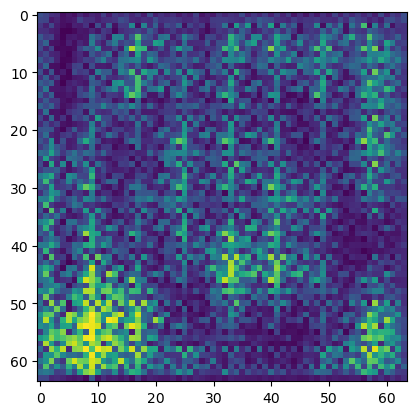

epoch = 21
Gen loss = tf.Tensor(0.12377688, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21422188, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 22
Gen loss = tf.Tensor(0.10417224, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2320763, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 23
Gen loss = tf.Tensor(0.11059677, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22705434, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 24
Gen loss = tf.Tensor(0.12080548, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20840971, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 25
Gen loss = tf.Tensor(0.11660588, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22648723, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 26
Gen loss = tf.Tensor(0.12091196, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2268828, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 27
Gen loss = tf.Tensor(0.115773164, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21657608, shape=(), 

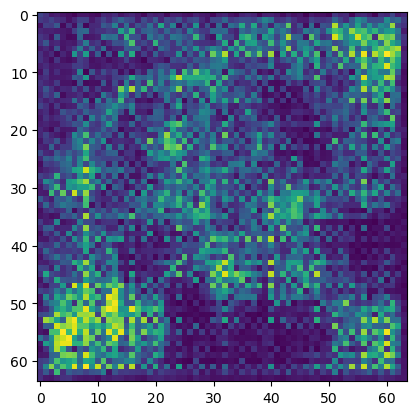

epoch = 31
Gen loss = tf.Tensor(0.09939927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25365642, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 32
Gen loss = tf.Tensor(0.09425252, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25702736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 33
Gen loss = tf.Tensor(0.09347565, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25448754, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 34
Gen loss = tf.Tensor(0.093172394, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24775417, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 35
Gen loss = tf.Tensor(0.09157338, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25211176, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 36
Gen loss = tf.Tensor(0.093571864, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.25297996, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 37
Gen loss = tf.Tensor(0.09511587, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24949007, shape=(

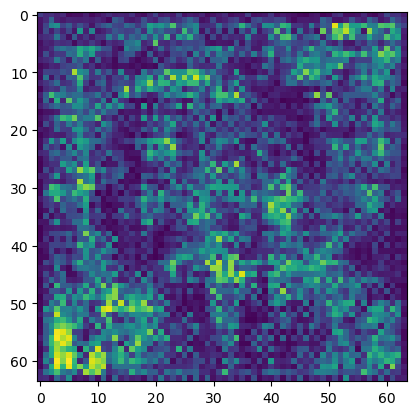

epoch = 41
Gen loss = tf.Tensor(0.096719645, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24631037, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 42
Gen loss = tf.Tensor(0.09889448, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24086966, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 43
Gen loss = tf.Tensor(0.096925594, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24373953, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 44
Gen loss = tf.Tensor(0.09987881, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24104154, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 45
Gen loss = tf.Tensor(0.0974774, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2399637, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 46
Gen loss = tf.Tensor(0.09809161, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23996411, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 47
Gen loss = tf.Tensor(0.09964622, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23761165, shape=(),

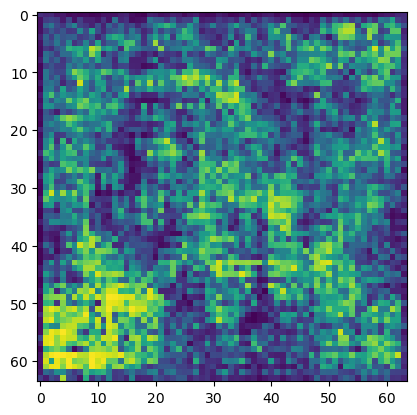

epoch = 51
Gen loss = tf.Tensor(0.10106594, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23520352, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 52
Gen loss = tf.Tensor(0.100987114, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23458348, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 53
Gen loss = tf.Tensor(0.10136038, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23424292, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 54
Gen loss = tf.Tensor(0.10077631, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23342295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 55
Gen loss = tf.Tensor(0.10145167, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23174192, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 56
Gen loss = tf.Tensor(0.09970504, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23312289, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 57
Gen loss = tf.Tensor(0.10219157, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23029362, shape=()

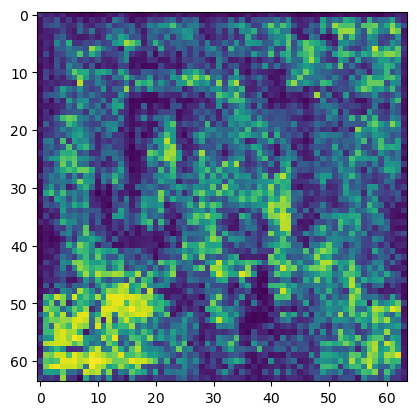

epoch = 61
Gen loss = tf.Tensor(0.10248489, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22823514, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 62
Gen loss = tf.Tensor(0.1025613, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2268216, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 63
Gen loss = tf.Tensor(0.102527805, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22763039, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 64
Gen loss = tf.Tensor(0.10277426, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22738282, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 65
Gen loss = tf.Tensor(0.10384416, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2271186, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 66
Gen loss = tf.Tensor(0.103660025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2260925, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 67
Gen loss = tf.Tensor(0.10277745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.226668, shape=(), dty

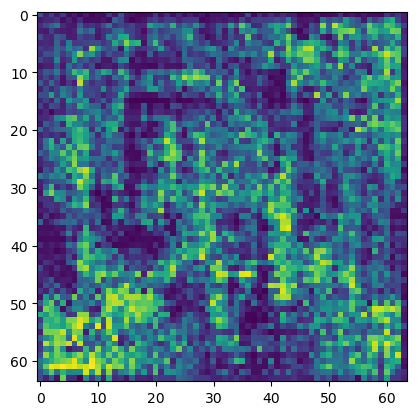

epoch = 71
Gen loss = tf.Tensor(0.103386424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22634679, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 72
Gen loss = tf.Tensor(0.101987936, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22655971, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 73
Gen loss = tf.Tensor(0.1027123, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2268793, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 74
Gen loss = tf.Tensor(0.103842795, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22606139, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 75
Gen loss = tf.Tensor(0.10399576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22544257, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 76
Gen loss = tf.Tensor(0.103717685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22705899, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 77
Gen loss = tf.Tensor(0.10386131, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2248032, shape=()

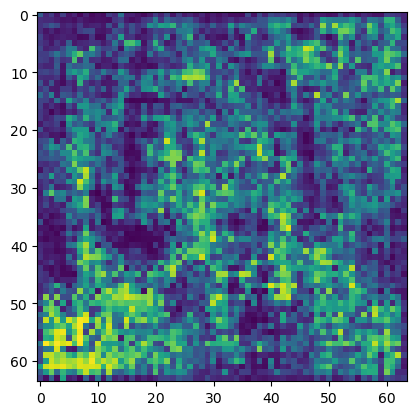

epoch = 81
Gen loss = tf.Tensor(0.10537389, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22360921, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 82
Gen loss = tf.Tensor(0.103971384, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22400545, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 83
Gen loss = tf.Tensor(0.103810616, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22262807, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 84
Gen loss = tf.Tensor(0.10394061, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2218376, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 85
Gen loss = tf.Tensor(0.10460048, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22310714, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 86
Gen loss = tf.Tensor(0.10609696, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22177984, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 87
Gen loss = tf.Tensor(0.10475478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22312915, shape=()

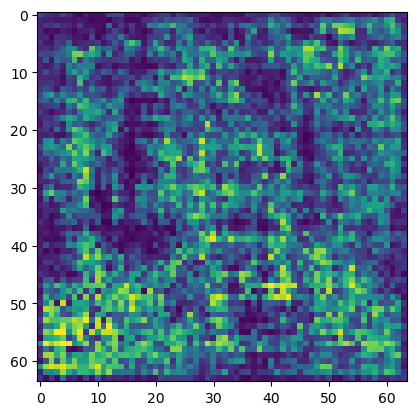

epoch = 91
Gen loss = tf.Tensor(0.10614702, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22199535, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 92
Gen loss = tf.Tensor(0.104541235, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22174655, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 93
Gen loss = tf.Tensor(0.10750442, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22094667, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 94
Gen loss = tf.Tensor(0.107667804, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22161676, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 95
Gen loss = tf.Tensor(0.10710176, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22130352, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 96
Gen loss = tf.Tensor(0.10596341, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22162126, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 97
Gen loss = tf.Tensor(0.106651574, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22078489, shape=

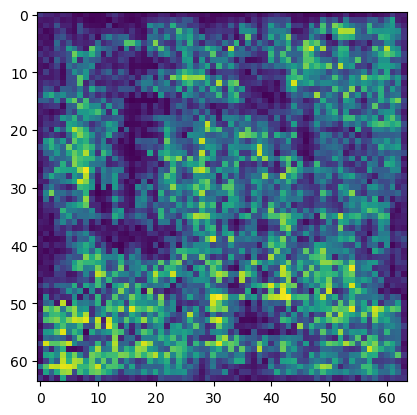

epoch = 101
Gen loss = tf.Tensor(0.10636666, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2200134, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 102
Gen loss = tf.Tensor(0.10569146, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22010337, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 103
Gen loss = tf.Tensor(0.106360324, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21998788, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 104
Gen loss = tf.Tensor(0.107308775, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21951218, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 105
Gen loss = tf.Tensor(0.10849359, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21867418, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 106
Gen loss = tf.Tensor(0.10610706, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21956827, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 107
Gen loss = tf.Tensor(0.10719865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21923907, s

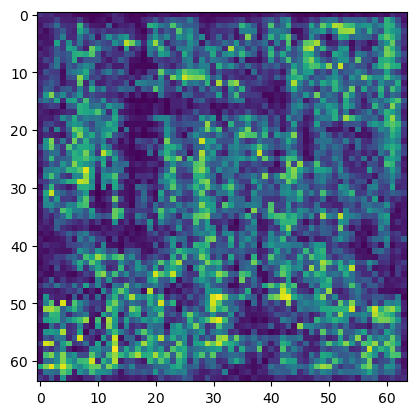

epoch = 111
Gen loss = tf.Tensor(0.10624298, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21730591, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 112
Gen loss = tf.Tensor(0.10764102, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21891518, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 113
Gen loss = tf.Tensor(0.10914478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21865408, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 114
Gen loss = tf.Tensor(0.107758604, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21840452, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 115
Gen loss = tf.Tensor(0.105724424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21726398, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 116
Gen loss = tf.Tensor(0.108200975, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21736558, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 117
Gen loss = tf.Tensor(0.10869411, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2174325, 

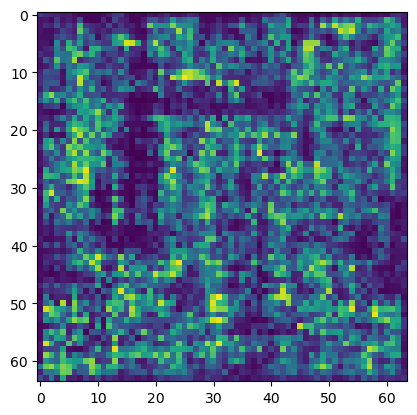

epoch = 121
Gen loss = tf.Tensor(0.106189154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2168227, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 122
Gen loss = tf.Tensor(0.10850507, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21773672, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 123
Gen loss = tf.Tensor(0.108622976, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21928823, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 124
Gen loss = tf.Tensor(0.10943229, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21617395, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 125
Gen loss = tf.Tensor(0.10938891, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21852519, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 126
Gen loss = tf.Tensor(0.1091881, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21528101, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 127
Gen loss = tf.Tensor(0.11016985, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21672054, sh

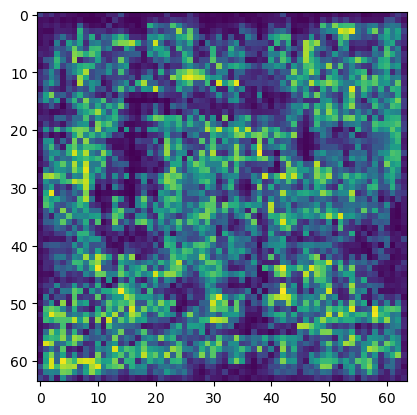

epoch = 131
Gen loss = tf.Tensor(0.10960532, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2146914, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 132
Gen loss = tf.Tensor(0.10643936, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21680023, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 133
Gen loss = tf.Tensor(0.10936189, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21619254, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 134
Gen loss = tf.Tensor(0.112798154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21464999, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 135
Gen loss = tf.Tensor(0.1123113, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21494997, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 136
Gen loss = tf.Tensor(0.10654819, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21504052, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 137
Gen loss = tf.Tensor(0.109674044, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21469535, sh

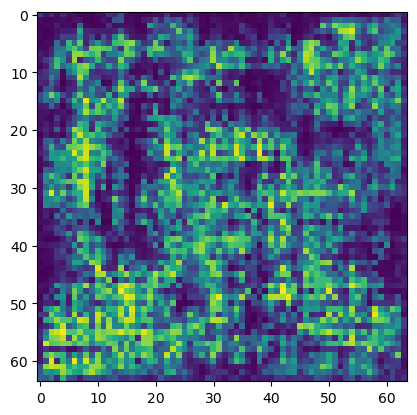

epoch = 141
Gen loss = tf.Tensor(0.1131744, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21391796, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 142
Gen loss = tf.Tensor(0.109556705, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21176314, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 143
Gen loss = tf.Tensor(0.110250436, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21508197, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 144
Gen loss = tf.Tensor(0.11212399, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21393776, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 145
Gen loss = tf.Tensor(0.11341947, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21198046, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 146
Gen loss = tf.Tensor(0.11164946, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21287759, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 147
Gen loss = tf.Tensor(0.10936433, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21342753, s

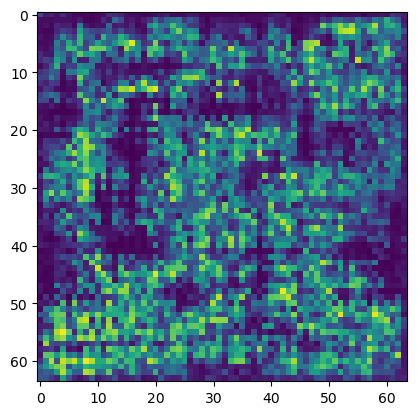

epoch = 151
Gen loss = tf.Tensor(0.11165979, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21348728, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 152
Gen loss = tf.Tensor(0.110478856, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21020995, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 153
Gen loss = tf.Tensor(0.1124568, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20932029, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 154
Gen loss = tf.Tensor(0.113106064, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21333157, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 155
Gen loss = tf.Tensor(0.11290132, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20975097, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 156
Gen loss = tf.Tensor(0.11365545, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21163099, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 157
Gen loss = tf.Tensor(0.10911859, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21012598, s

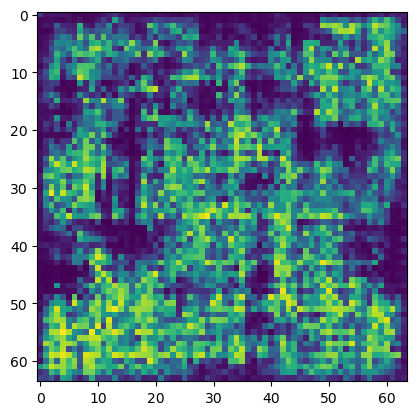

epoch = 161
Gen loss = tf.Tensor(0.11327807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21480902, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 162
Gen loss = tf.Tensor(0.11950377, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20653935, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 163
Gen loss = tf.Tensor(0.12027517, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20209222, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 164
Gen loss = tf.Tensor(0.11310073, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20701802, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 165
Gen loss = tf.Tensor(0.11797086, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19940288, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 166
Gen loss = tf.Tensor(0.122747295, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21162587, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 167
Gen loss = tf.Tensor(0.12156867, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19650958, s

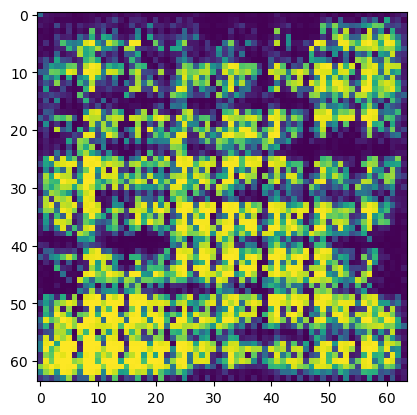

epoch = 171
Gen loss = tf.Tensor(0.14966895, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18189241, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 172
Gen loss = tf.Tensor(0.13807394, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1566002, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 173
Gen loss = tf.Tensor(0.13802485, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17629285, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 174
Gen loss = tf.Tensor(0.14233898, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19316363, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 175
Gen loss = tf.Tensor(0.15251787, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18875785, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 176
Gen loss = tf.Tensor(0.115785636, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1725688, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 177
Gen loss = tf.Tensor(0.12960128, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18446344, sha

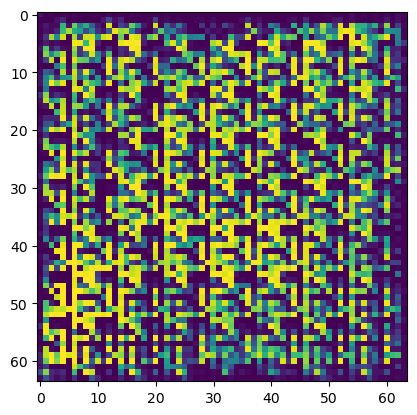

epoch = 181
Gen loss = tf.Tensor(0.13348421, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17653699, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 182
Gen loss = tf.Tensor(0.14195277, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.161997, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 183
Gen loss = tf.Tensor(0.15988378, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15379177, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 184
Gen loss = tf.Tensor(0.13613239, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21113233, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 185
Gen loss = tf.Tensor(0.12417904, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20456614, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 186
Gen loss = tf.Tensor(0.13965084, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19228111, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 187
Gen loss = tf.Tensor(0.13352533, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18806268, shap

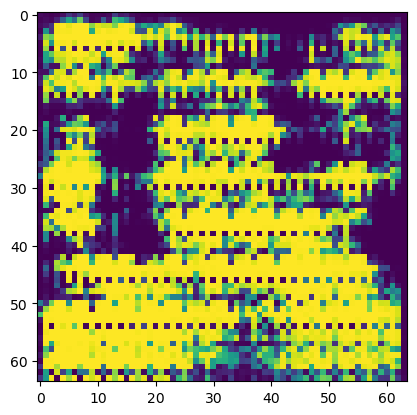

epoch = 191
Gen loss = tf.Tensor(0.15242924, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1659614, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 192
Gen loss = tf.Tensor(0.14472283, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15399599, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 193
Gen loss = tf.Tensor(0.14295079, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16177562, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 194
Gen loss = tf.Tensor(0.15557088, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1742398, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 195
Gen loss = tf.Tensor(0.1387646, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19410034, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 196
Gen loss = tf.Tensor(0.15940808, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15344684, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 197
Gen loss = tf.Tensor(0.16753215, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.120839596, shap

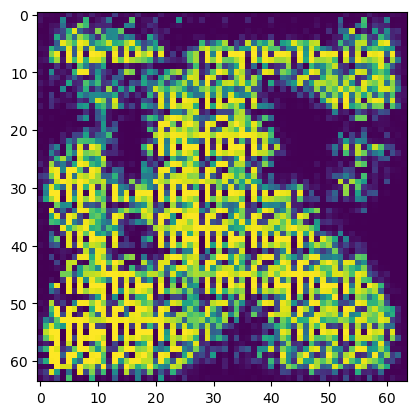

epoch = 201
Gen loss = tf.Tensor(0.1379674, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18782777, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 202
Gen loss = tf.Tensor(0.12304147, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1966906, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 203
Gen loss = tf.Tensor(0.14438027, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17929006, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 204
Gen loss = tf.Tensor(0.13049264, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21460408, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 205
Gen loss = tf.Tensor(0.121192075, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19851492, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 206
Gen loss = tf.Tensor(0.11203834, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22375779, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 207
Gen loss = tf.Tensor(0.08531036, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.24961068, sha

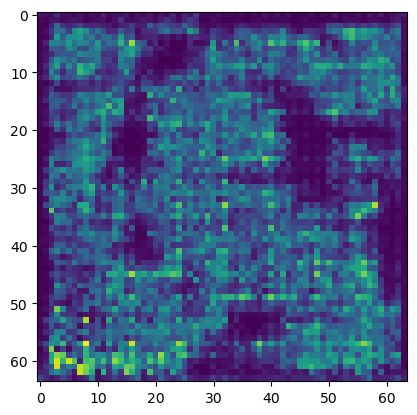

epoch = 211
Gen loss = tf.Tensor(0.0921084, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23987938, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 212
Gen loss = tf.Tensor(0.096030176, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.23841536, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 213
Gen loss = tf.Tensor(0.0951665, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.235777, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 214
Gen loss = tf.Tensor(0.093941264, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22845845, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 215
Gen loss = tf.Tensor(0.09812128, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22549468, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 216
Gen loss = tf.Tensor(0.09998658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22339512, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 217
Gen loss = tf.Tensor(0.10165868, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.22047333, shap

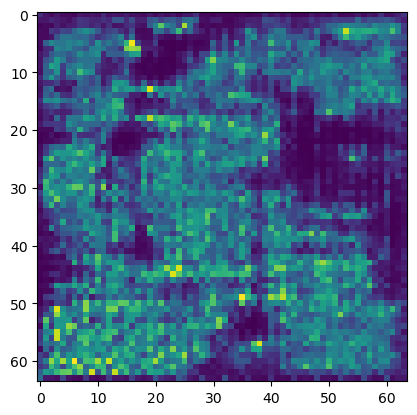

epoch = 221
Gen loss = tf.Tensor(0.10517884, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21902741, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 222
Gen loss = tf.Tensor(0.105241, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21772017, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 223
Gen loss = tf.Tensor(0.10631511, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21723068, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 224
Gen loss = tf.Tensor(0.1085669, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21736367, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 225
Gen loss = tf.Tensor(0.10684345, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21487182, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 226
Gen loss = tf.Tensor(0.109340064, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21439265, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 227
Gen loss = tf.Tensor(0.10910517, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21484102, shap

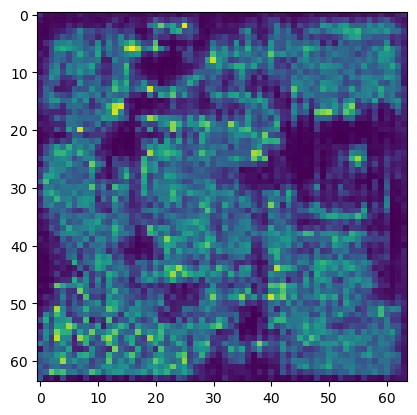

epoch = 231
Gen loss = tf.Tensor(0.10958513, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21058266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 232
Gen loss = tf.Tensor(0.11013028, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21108733, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 233
Gen loss = tf.Tensor(0.11528777, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20689313, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 234
Gen loss = tf.Tensor(0.11017516, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20746864, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 235
Gen loss = tf.Tensor(0.11376508, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20944238, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 236
Gen loss = tf.Tensor(0.11073562, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20853497, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 237
Gen loss = tf.Tensor(0.1104233, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20953166, sha

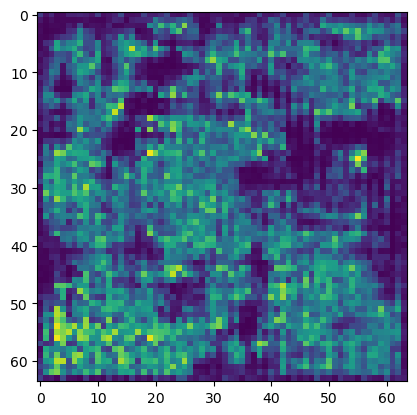

epoch = 241
Gen loss = tf.Tensor(0.11519558, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20905042, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 242
Gen loss = tf.Tensor(0.11269959, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20451634, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 243
Gen loss = tf.Tensor(0.11806028, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20276119, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 244
Gen loss = tf.Tensor(0.11793663, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.205518, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 245
Gen loss = tf.Tensor(0.116048455, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20335244, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 246
Gen loss = tf.Tensor(0.11398827, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20232417, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 247
Gen loss = tf.Tensor(0.120085835, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20449412, sh

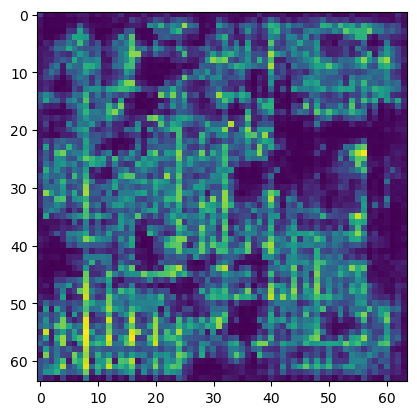

epoch = 251
Gen loss = tf.Tensor(0.12250642, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20504828, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 252
Gen loss = tf.Tensor(0.12397643, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20199287, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 253
Gen loss = tf.Tensor(0.11519141, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.2035408, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 254
Gen loss = tf.Tensor(0.11836404, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20223705, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 255
Gen loss = tf.Tensor(0.11733154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20432208, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 256
Gen loss = tf.Tensor(0.11911554, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20173015, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 257
Gen loss = tf.Tensor(0.11756927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20093514, sha

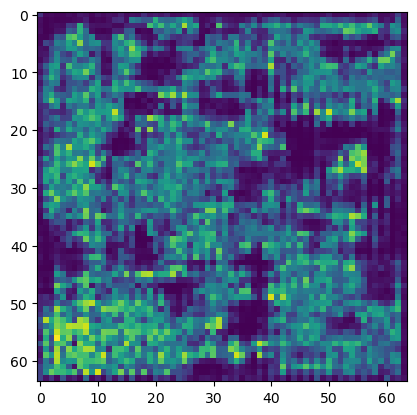

epoch = 261
Gen loss = tf.Tensor(0.119892575, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1969742, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 262
Gen loss = tf.Tensor(0.12263859, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.20058881, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 263
Gen loss = tf.Tensor(0.118909575, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19870281, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 264
Gen loss = tf.Tensor(0.11890334, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19692475, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 265
Gen loss = tf.Tensor(0.121412195, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19907302, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 266
Gen loss = tf.Tensor(0.12193682, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19845295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 267
Gen loss = tf.Tensor(0.11974739, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19938934, 

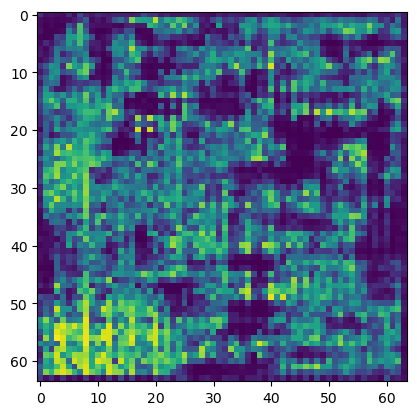

epoch = 271
Gen loss = tf.Tensor(0.12365989, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19738169, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 272
Gen loss = tf.Tensor(0.12209993, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19644444, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 273
Gen loss = tf.Tensor(0.12085143, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19335349, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 274
Gen loss = tf.Tensor(0.12813677, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19350885, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 275
Gen loss = tf.Tensor(0.12027385, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19527316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 276
Gen loss = tf.Tensor(0.12789965, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19067644, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 277
Gen loss = tf.Tensor(0.12676732, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19359823, sh

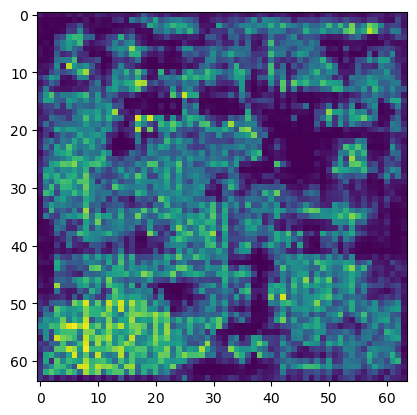

epoch = 281
Gen loss = tf.Tensor(0.12751777, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19062704, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 282
Gen loss = tf.Tensor(0.12640896, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18777496, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 283
Gen loss = tf.Tensor(0.12399002, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19047697, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 284
Gen loss = tf.Tensor(0.12706523, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18522589, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 285
Gen loss = tf.Tensor(0.1304584, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18506022, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 286
Gen loss = tf.Tensor(0.13044462, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18105112, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 287
Gen loss = tf.Tensor(0.1425148, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17364357, shap

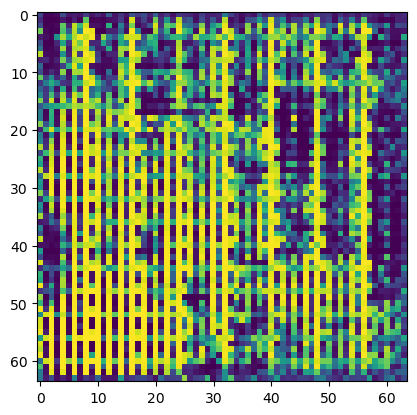

epoch = 291
Gen loss = tf.Tensor(0.15622711, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17697556, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 292
Gen loss = tf.Tensor(0.18724017, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14128925, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 293
Gen loss = tf.Tensor(0.16079438, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14929603, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 294
Gen loss = tf.Tensor(0.17287521, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14608492, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 295
Gen loss = tf.Tensor(0.14640598, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17529857, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 296
Gen loss = tf.Tensor(0.16141574, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15674944, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 297
Gen loss = tf.Tensor(0.16060516, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15787661, sh

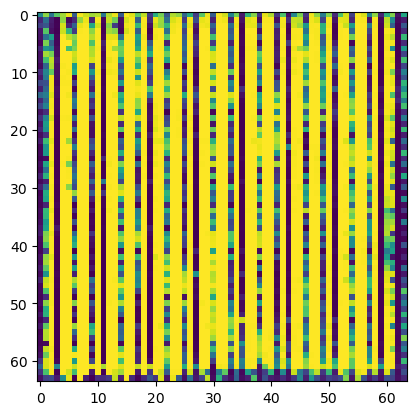

epoch = 301
Gen loss = tf.Tensor(0.19077551, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13932584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 302
Gen loss = tf.Tensor(0.20048942, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14382195, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 303
Gen loss = tf.Tensor(0.17284983, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1724776, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 304
Gen loss = tf.Tensor(0.22097047, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.109682165, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 305
Gen loss = tf.Tensor(0.21298458, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11911464, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 306
Gen loss = tf.Tensor(0.20044212, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14601184, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 307
Gen loss = tf.Tensor(0.19418615, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13167453, sh

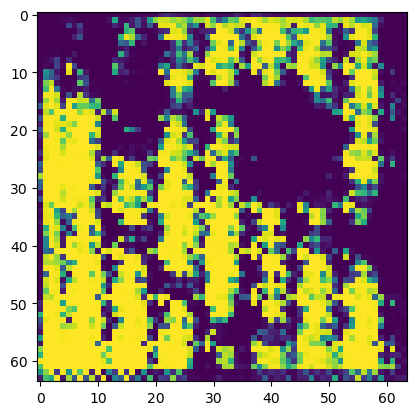

epoch = 311
Gen loss = tf.Tensor(0.20947923, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13664775, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 312
Gen loss = tf.Tensor(0.2746878, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07944547, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 313
Gen loss = tf.Tensor(0.23673235, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08794551, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 314
Gen loss = tf.Tensor(0.2521864, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07377518, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 315
Gen loss = tf.Tensor(0.2679159, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06955282, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 316
Gen loss = tf.Tensor(0.24403052, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07908766, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 317
Gen loss = tf.Tensor(0.25218567, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07727134, shape

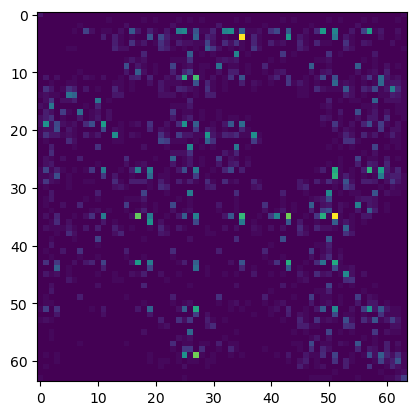

epoch = 321
Gen loss = tf.Tensor(0.15981454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09066511, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 322
Gen loss = tf.Tensor(0.20011725, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07517815, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 323
Gen loss = tf.Tensor(0.23895872, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.082624316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 324
Gen loss = tf.Tensor(0.17536958, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15202118, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 325
Gen loss = tf.Tensor(0.14381841, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.21128845, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 326
Gen loss = tf.Tensor(0.16241996, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14772242, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 327
Gen loss = tf.Tensor(0.16001366, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18847376, s

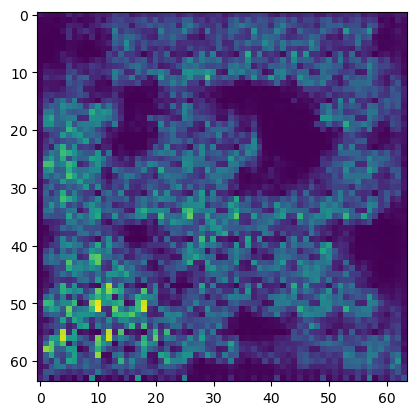

epoch = 331
Gen loss = tf.Tensor(0.13600081, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19686703, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 332
Gen loss = tf.Tensor(0.13063957, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19580597, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 333
Gen loss = tf.Tensor(0.12686808, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18753207, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 334
Gen loss = tf.Tensor(0.13319182, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18163042, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 335
Gen loss = tf.Tensor(0.14436258, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16989131, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 336
Gen loss = tf.Tensor(0.1395754, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17782561, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 337
Gen loss = tf.Tensor(0.14166398, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16753119, sha

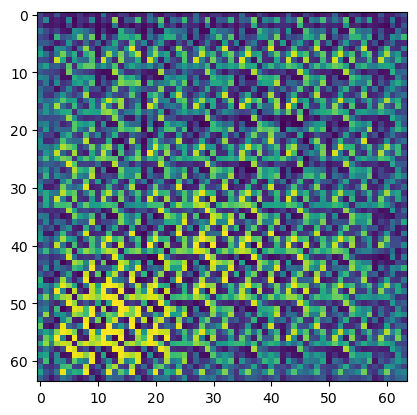

epoch = 341
Gen loss = tf.Tensor(0.15531519, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14655411, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 342
Gen loss = tf.Tensor(0.17916948, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15998513, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 343
Gen loss = tf.Tensor(0.20005377, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13291702, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 344
Gen loss = tf.Tensor(0.16524917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14390531, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 345
Gen loss = tf.Tensor(0.16897424, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1384608, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 346
Gen loss = tf.Tensor(0.17996025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14142787, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 347
Gen loss = tf.Tensor(0.14152353, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19302212, sha

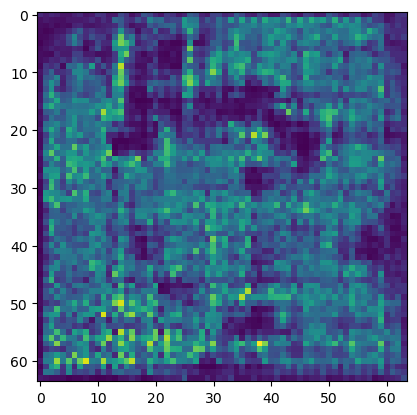

epoch = 351
Gen loss = tf.Tensor(0.13318641, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18405545, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 352
Gen loss = tf.Tensor(0.14228247, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18401347, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 353
Gen loss = tf.Tensor(0.13863534, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.18485634, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 354
Gen loss = tf.Tensor(0.14413576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1737647, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 355
Gen loss = tf.Tensor(0.14413841, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17253256, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 356
Gen loss = tf.Tensor(0.14712012, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1664132, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 357
Gen loss = tf.Tensor(0.15026338, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1692753, shape

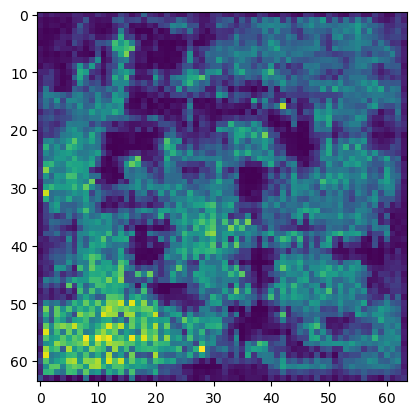

epoch = 361
Gen loss = tf.Tensor(0.13736264, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.17972745, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 362
Gen loss = tf.Tensor(0.22240923, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11584192, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 363
Gen loss = tf.Tensor(0.17881258, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14020716, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 364
Gen loss = tf.Tensor(0.16604309, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15360296, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 365
Gen loss = tf.Tensor(0.17090933, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14388801, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 366
Gen loss = tf.Tensor(0.16539569, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15803784, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 367
Gen loss = tf.Tensor(0.17438807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14514257, sh

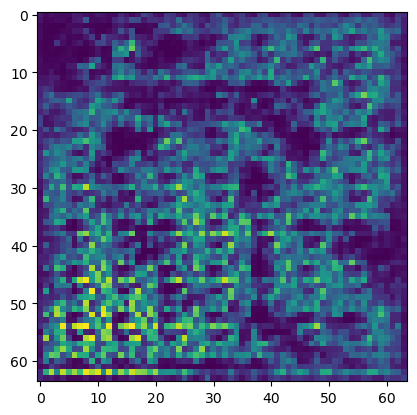

epoch = 371
Gen loss = tf.Tensor(0.17614704, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13463527, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 372
Gen loss = tf.Tensor(0.15393347, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16013639, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 373
Gen loss = tf.Tensor(0.16177899, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15385787, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 374
Gen loss = tf.Tensor(0.16846174, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14451234, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 375
Gen loss = tf.Tensor(0.17659973, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13676746, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 376
Gen loss = tf.Tensor(0.17194046, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14565694, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 377
Gen loss = tf.Tensor(0.15396126, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16898148, sh

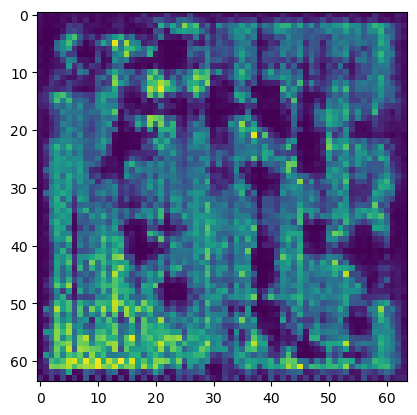

epoch = 381
Gen loss = tf.Tensor(0.16252445, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16006772, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 382
Gen loss = tf.Tensor(0.15841253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15792313, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 383
Gen loss = tf.Tensor(0.16290694, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16102946, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 384
Gen loss = tf.Tensor(0.15876706, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16047366, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 385
Gen loss = tf.Tensor(0.15565337, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16986392, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 386
Gen loss = tf.Tensor(0.15923066, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16227758, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 387
Gen loss = tf.Tensor(0.15813248, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15944363, sh

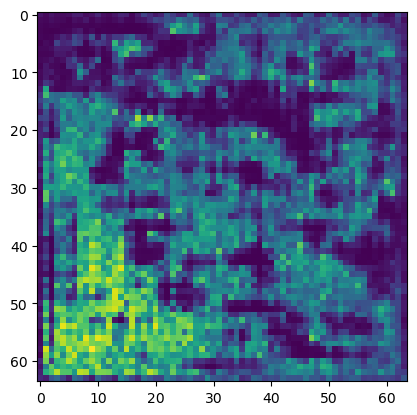

epoch = 391
Gen loss = tf.Tensor(0.16300946, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15501727, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 392
Gen loss = tf.Tensor(0.15911846, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16168733, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 393
Gen loss = tf.Tensor(0.16288443, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15806843, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 394
Gen loss = tf.Tensor(0.16159797, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15459369, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 395
Gen loss = tf.Tensor(0.16092835, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16031954, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 396
Gen loss = tf.Tensor(0.15835965, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15636082, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 397
Gen loss = tf.Tensor(0.16176103, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15463264, sh

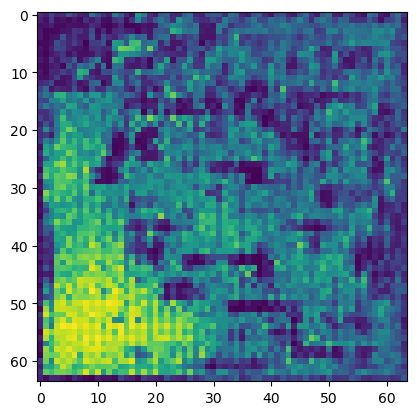

epoch = 401
Gen loss = tf.Tensor(0.16407369, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15206507, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 402
Gen loss = tf.Tensor(0.16210292, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15795416, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 403
Gen loss = tf.Tensor(0.16934194, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15045814, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 404
Gen loss = tf.Tensor(0.16020967, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16238302, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 405
Gen loss = tf.Tensor(0.16427127, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15587491, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 406
Gen loss = tf.Tensor(0.16395904, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1574653, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 407
Gen loss = tf.Tensor(0.1607237, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.16101316, shap

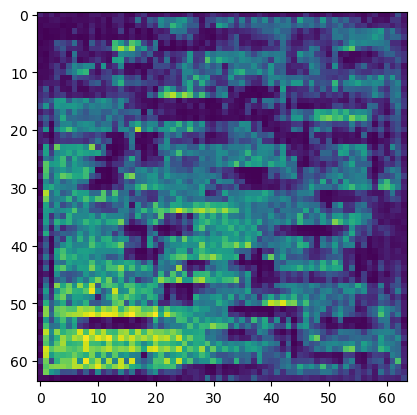

epoch = 411
Gen loss = tf.Tensor(0.1529576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1668363, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 412
Gen loss = tf.Tensor(0.16067807, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1572629, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 413
Gen loss = tf.Tensor(0.1654345, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.15430939, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 414
Gen loss = tf.Tensor(0.17858718, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14616999, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 415
Gen loss = tf.Tensor(0.1753643, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1472698, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 416
Gen loss = tf.Tensor(0.18282871, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13789062, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 417
Gen loss = tf.Tensor(0.18108737, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13768591, shape=()

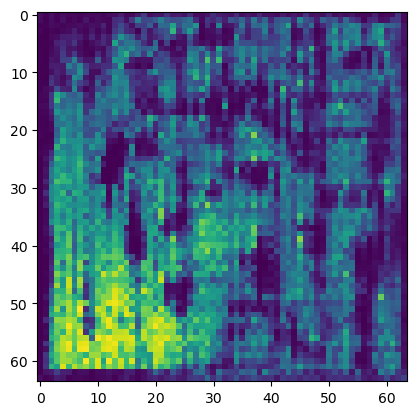

epoch = 421
Gen loss = tf.Tensor(0.18398048, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1400658, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 422
Gen loss = tf.Tensor(0.21414465, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11120344, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 423
Gen loss = tf.Tensor(0.27136353, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08096263, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 424
Gen loss = tf.Tensor(0.21849112, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13133775, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 425
Gen loss = tf.Tensor(0.156005, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.19717772, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 426
Gen loss = tf.Tensor(0.42758927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05299676, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 427
Gen loss = tf.Tensor(0.5807235, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015072758, shape

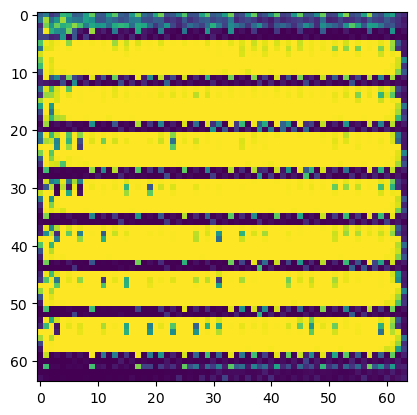

epoch = 431
Gen loss = tf.Tensor(0.2781922, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08925963, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 432
Gen loss = tf.Tensor(0.35293865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041328896, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 433
Gen loss = tf.Tensor(0.42571768, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02631779, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 434
Gen loss = tf.Tensor(0.3706673, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03432053, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 435
Gen loss = tf.Tensor(0.32880798, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046585742, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 436
Gen loss = tf.Tensor(0.28361025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07432569, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 437
Gen loss = tf.Tensor(0.37206706, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04841144, sh

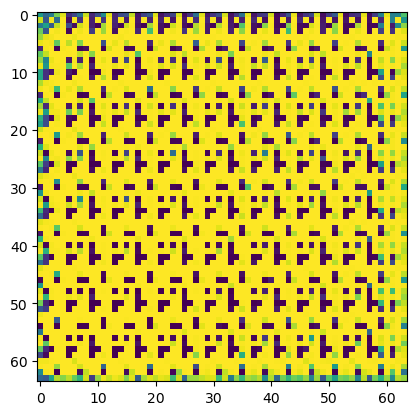

epoch = 441
Gen loss = tf.Tensor(0.47150648, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02243288, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 442
Gen loss = tf.Tensor(0.40653685, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026391715, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 443
Gen loss = tf.Tensor(0.4479905, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.023378277, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 444
Gen loss = tf.Tensor(0.5206479, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015372603, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 445
Gen loss = tf.Tensor(0.49977067, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.013206523, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 446
Gen loss = tf.Tensor(0.4058847, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.024173483, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 447
Gen loss = tf.Tensor(0.4387951, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.026493907, 

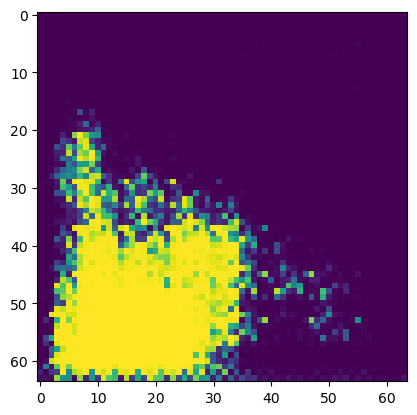

epoch = 451
Gen loss = tf.Tensor(0.28726786, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061992988, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 452
Gen loss = tf.Tensor(0.33223394, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049760282, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 453
Gen loss = tf.Tensor(0.36034203, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04544103, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 454
Gen loss = tf.Tensor(0.36648285, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049451206, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 455
Gen loss = tf.Tensor(0.31298944, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067142405, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 456
Gen loss = tf.Tensor(0.2766432, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06935062, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 457
Gen loss = tf.Tensor(0.30794212, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06797934,

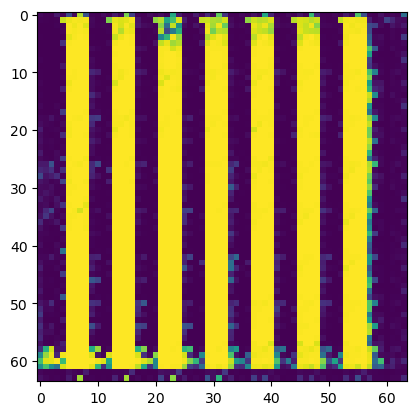

epoch = 461
Gen loss = tf.Tensor(0.7444745, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.004402625, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 462
Gen loss = tf.Tensor(0.7723231, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0037929695, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 463
Gen loss = tf.Tensor(0.36885247, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04022489, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 464
Gen loss = tf.Tensor(0.37209213, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.052033838, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 465
Gen loss = tf.Tensor(0.41536692, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.02915513, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 466
Gen loss = tf.Tensor(0.27882725, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10696611, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 467
Gen loss = tf.Tensor(0.24963458, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13947736, 

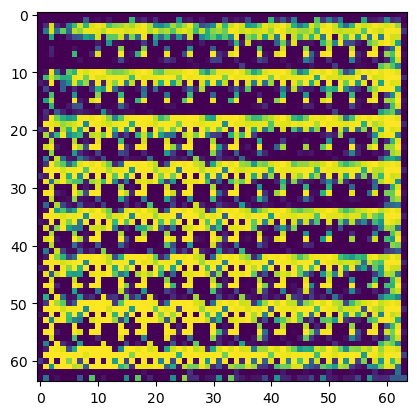

epoch = 471
Gen loss = tf.Tensor(0.33373865, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0672935, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 472
Gen loss = tf.Tensor(0.23852973, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10507042, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 473
Gen loss = tf.Tensor(0.314639, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06303814, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 474
Gen loss = tf.Tensor(0.35175872, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042434145, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 475
Gen loss = tf.Tensor(0.2745881, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07404328, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 476
Gen loss = tf.Tensor(0.33262977, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.067173205, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 477
Gen loss = tf.Tensor(0.32437757, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06237868, shap

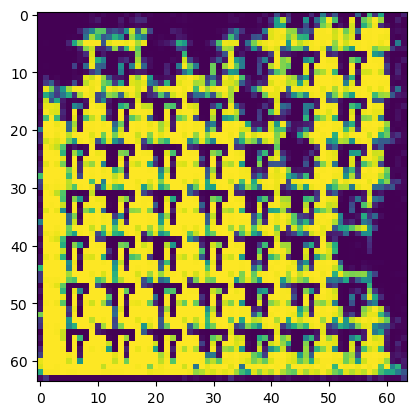

epoch = 481
Gen loss = tf.Tensor(0.3237012, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05878593, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 482
Gen loss = tf.Tensor(0.3486501, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047157675, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 483
Gen loss = tf.Tensor(0.27751383, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07168552, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 484
Gen loss = tf.Tensor(0.33354226, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05521947, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 485
Gen loss = tf.Tensor(0.35361502, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040115207, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 486
Gen loss = tf.Tensor(0.35269547, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04139976, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 487
Gen loss = tf.Tensor(0.30863675, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06856636, sh

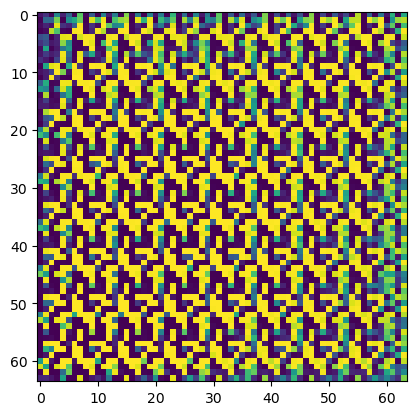

epoch = 491
Gen loss = tf.Tensor(0.36362144, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039930727, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 492
Gen loss = tf.Tensor(0.4251189, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.030939266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 493
Gen loss = tf.Tensor(0.4913253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.01796371, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 494
Gen loss = tf.Tensor(0.49648222, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.015274558, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 495
Gen loss = tf.Tensor(0.38682607, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028638802, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 496
Gen loss = tf.Tensor(0.5098441, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019317042, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 497
Gen loss = tf.Tensor(0.4733707, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.018028451, 

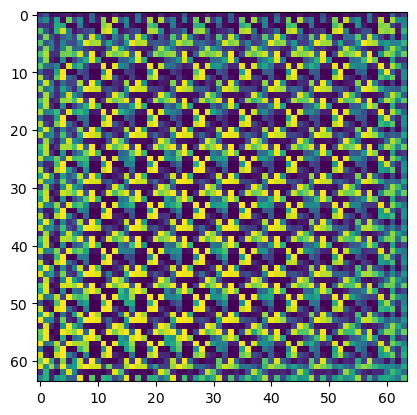

epoch = 501
Gen loss = tf.Tensor(0.4804708, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.020557221, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 502
Gen loss = tf.Tensor(0.3931966, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03392401, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 503
Gen loss = tf.Tensor(0.2363075, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11658522, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 504
Gen loss = tf.Tensor(0.28489658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11623057, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 505
Gen loss = tf.Tensor(0.34402236, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06784602, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 506
Gen loss = tf.Tensor(0.34284207, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06259584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 507
Gen loss = tf.Tensor(0.16757256, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.14926918, shap

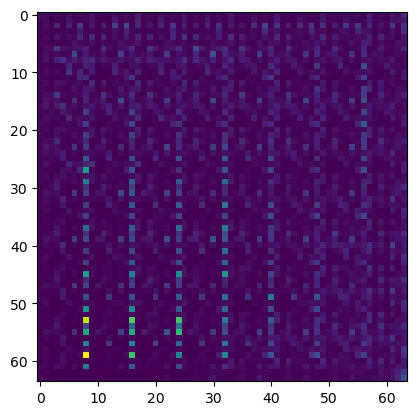

epoch = 511
Gen loss = tf.Tensor(0.34952208, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056421775, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 512
Gen loss = tf.Tensor(0.51948065, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.035452724, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 513
Gen loss = tf.Tensor(0.3749584, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.030482426, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 514
Gen loss = tf.Tensor(0.30361363, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.035937373, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 515
Gen loss = tf.Tensor(0.33056405, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037345584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 516
Gen loss = tf.Tensor(0.35477844, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.032530453, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 517
Gen loss = tf.Tensor(0.34877673, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0374719

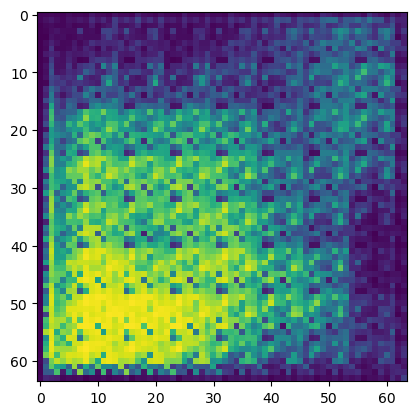

epoch = 521
Gen loss = tf.Tensor(0.234774, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13261302, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 522
Gen loss = tf.Tensor(0.29825363, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09947172, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 523
Gen loss = tf.Tensor(0.2569109, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.091985084, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 524
Gen loss = tf.Tensor(0.24306189, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.096900284, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 525
Gen loss = tf.Tensor(0.30298254, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0780142, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 526
Gen loss = tf.Tensor(0.23343809, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11116316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 527
Gen loss = tf.Tensor(0.27104938, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12655413, shap

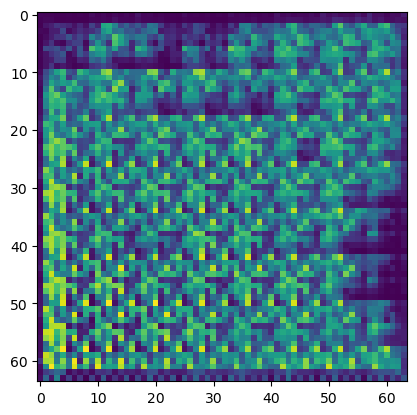

epoch = 531
Gen loss = tf.Tensor(0.27868232, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09916174, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 532
Gen loss = tf.Tensor(0.26285842, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12830295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 533
Gen loss = tf.Tensor(0.31359497, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07750303, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 534
Gen loss = tf.Tensor(0.32710567, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.063266136, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 535
Gen loss = tf.Tensor(0.26337135, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.087772764, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 536
Gen loss = tf.Tensor(0.22110794, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12263447, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 537
Gen loss = tf.Tensor(0.23702663, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.109226845,

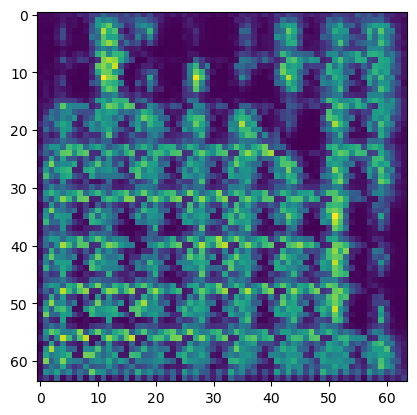

epoch = 541
Gen loss = tf.Tensor(0.29347262, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.081987105, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 542
Gen loss = tf.Tensor(0.27560788, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.088526584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 543
Gen loss = tf.Tensor(0.19625336, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1529373, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 544
Gen loss = tf.Tensor(0.2114014, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.13342483, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 545
Gen loss = tf.Tensor(0.2567616, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09967398, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 546
Gen loss = tf.Tensor(0.24854995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.106419295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 547
Gen loss = tf.Tensor(0.25094488, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.101650625, s

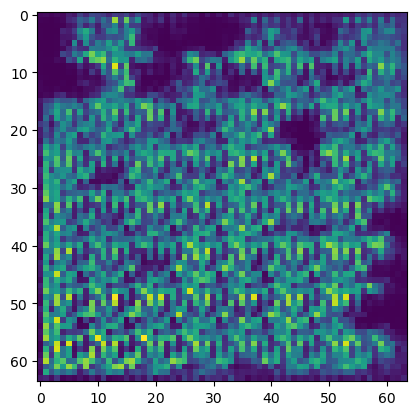

epoch = 551
Gen loss = tf.Tensor(0.28478923, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08205704, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 552
Gen loss = tf.Tensor(0.25013784, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09517295, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 553
Gen loss = tf.Tensor(0.24840993, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11443034, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 554
Gen loss = tf.Tensor(0.24901526, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10380327, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 555
Gen loss = tf.Tensor(0.30549917, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.080919005, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 556
Gen loss = tf.Tensor(0.3728318, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.046466127, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 557
Gen loss = tf.Tensor(0.24506496, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12296533, s

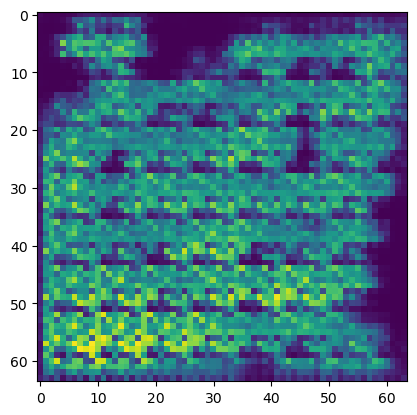

epoch = 561
Gen loss = tf.Tensor(0.31723207, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06544351, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 562
Gen loss = tf.Tensor(0.28952405, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08393771, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 563
Gen loss = tf.Tensor(0.25128826, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11454266, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 564
Gen loss = tf.Tensor(0.28969207, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09130561, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 565
Gen loss = tf.Tensor(0.2600972, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10061949, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 566
Gen loss = tf.Tensor(0.25589025, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10578972, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 567
Gen loss = tf.Tensor(0.24706222, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09966735, sha

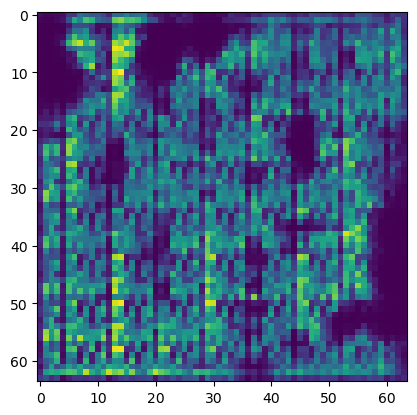

epoch = 571
Gen loss = tf.Tensor(0.2662761, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09726388, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 572
Gen loss = tf.Tensor(0.2928929, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.080075584, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 573
Gen loss = tf.Tensor(0.30113977, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07140838, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 574
Gen loss = tf.Tensor(0.26705298, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.088910885, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 575
Gen loss = tf.Tensor(0.27629617, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084679, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 576
Gen loss = tf.Tensor(0.26669645, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0865446, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 577
Gen loss = tf.Tensor(0.26241985, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09904813, shape

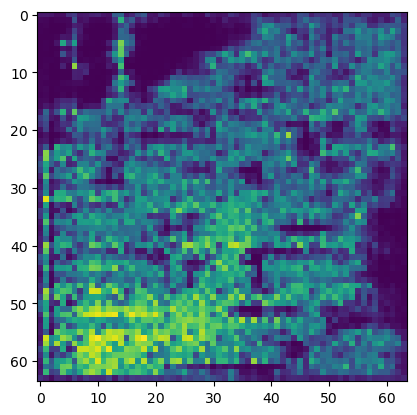

epoch = 581
Gen loss = tf.Tensor(0.22360633, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1279841, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 582
Gen loss = tf.Tensor(0.23494016, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12210926, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 583
Gen loss = tf.Tensor(0.24278146, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.112995826, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 584
Gen loss = tf.Tensor(0.25390503, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10762324, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 585
Gen loss = tf.Tensor(0.2527753, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09851018, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 586
Gen loss = tf.Tensor(0.26221073, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0924172, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 587
Gen loss = tf.Tensor(0.23818226, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.104937635, sha

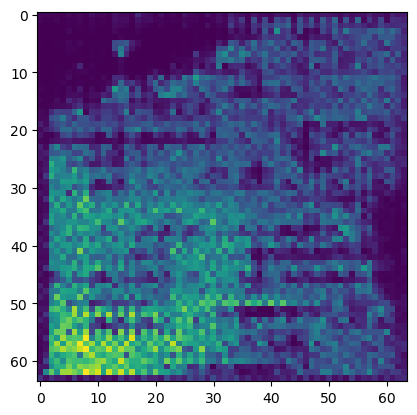

epoch = 591
Gen loss = tf.Tensor(0.24667464, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.103445955, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 592
Gen loss = tf.Tensor(0.25842968, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.113441736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 593
Gen loss = tf.Tensor(0.25027502, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10564939, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 594
Gen loss = tf.Tensor(0.2497906, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10249441, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 595
Gen loss = tf.Tensor(0.25625655, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10011361, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 596
Gen loss = tf.Tensor(0.27650037, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09090125, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 597
Gen loss = tf.Tensor(0.27028742, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08979192, s

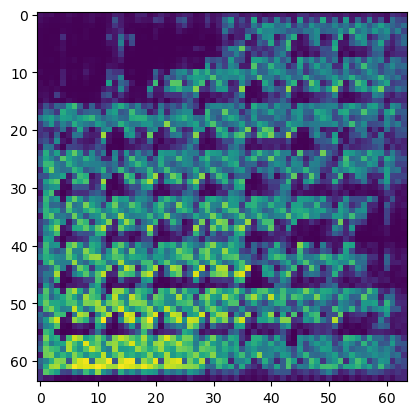

epoch = 601
Gen loss = tf.Tensor(0.25647977, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10685456, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 602
Gen loss = tf.Tensor(0.26333746, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09175176, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 603
Gen loss = tf.Tensor(0.25843439, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1065388, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 604
Gen loss = tf.Tensor(0.30846074, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06953367, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 605
Gen loss = tf.Tensor(0.26640192, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.094406605, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 606
Gen loss = tf.Tensor(0.41281927, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039811082, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 607
Gen loss = tf.Tensor(0.43094793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.031588476, 

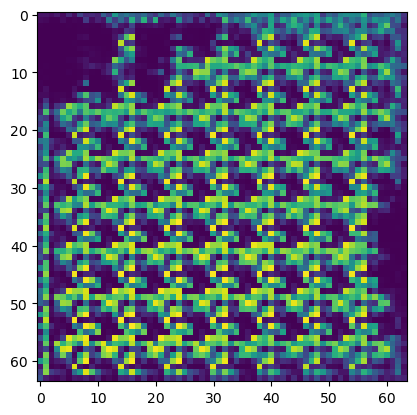

epoch = 611
Gen loss = tf.Tensor(0.32551184, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060318917, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 612
Gen loss = tf.Tensor(0.37827292, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041081503, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 613
Gen loss = tf.Tensor(0.34250474, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054615352, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 614
Gen loss = tf.Tensor(0.3187449, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08065302, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 615
Gen loss = tf.Tensor(0.3022212, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07326466, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 616
Gen loss = tf.Tensor(0.30454454, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057445522, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 617
Gen loss = tf.Tensor(0.36451006, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04396923, 

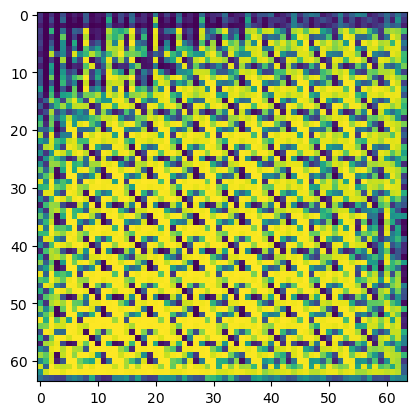

epoch = 621
Gen loss = tf.Tensor(0.39092323, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04315048, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 622
Gen loss = tf.Tensor(0.34783635, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05397804, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 623
Gen loss = tf.Tensor(0.34312448, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05419909, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 624
Gen loss = tf.Tensor(0.3034701, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06326801, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 625
Gen loss = tf.Tensor(0.33391154, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.062465493, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 626
Gen loss = tf.Tensor(0.3637298, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06668832, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 627
Gen loss = tf.Tensor(0.36590266, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07132887, sha

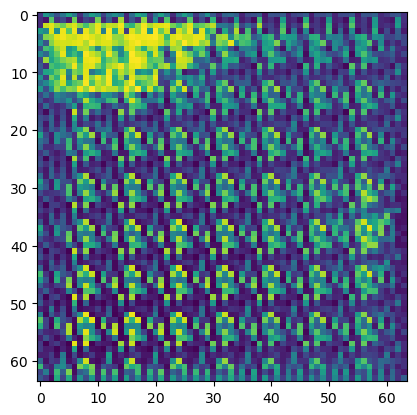

epoch = 631
Gen loss = tf.Tensor(0.24848096, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11800534, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 632
Gen loss = tf.Tensor(0.3283417, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08947388, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 633
Gen loss = tf.Tensor(0.33317062, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.073741496, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 634
Gen loss = tf.Tensor(0.3596038, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.056183834, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 635
Gen loss = tf.Tensor(0.3697256, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06985722, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 636
Gen loss = tf.Tensor(0.27864936, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09794188, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 637
Gen loss = tf.Tensor(0.27209595, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.101162076, sh

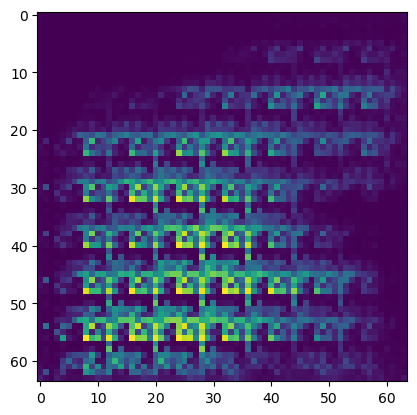

epoch = 641
Gen loss = tf.Tensor(0.39904976, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040592737, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 642
Gen loss = tf.Tensor(0.41924694, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.035817493, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 643
Gen loss = tf.Tensor(0.38690922, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.045365736, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 644
Gen loss = tf.Tensor(0.36728632, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.065731056, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 645
Gen loss = tf.Tensor(0.30797386, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.069980316, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 646
Gen loss = tf.Tensor(0.2992521, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.076127, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 647
Gen loss = tf.Tensor(0.27242032, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08182897, 

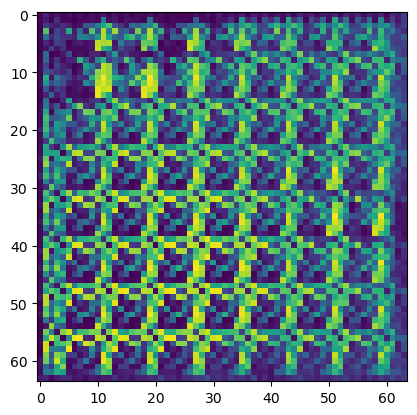

epoch = 651
Gen loss = tf.Tensor(0.39818013, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.035804003, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 652
Gen loss = tf.Tensor(0.32030532, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.064525396, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 653
Gen loss = tf.Tensor(0.29597393, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10113155, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 654
Gen loss = tf.Tensor(0.276978, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.084002204, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 655
Gen loss = tf.Tensor(0.3837643, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04496624, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 656
Gen loss = tf.Tensor(0.3830483, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044230565, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 657
Gen loss = tf.Tensor(0.32676318, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06682364, sh

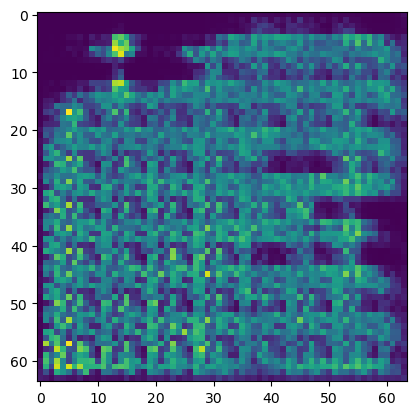

epoch = 661
Gen loss = tf.Tensor(0.2958428, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.078781925, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 662
Gen loss = tf.Tensor(0.2789719, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.090859555, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 663
Gen loss = tf.Tensor(0.22981952, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.12897621, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 664
Gen loss = tf.Tensor(0.32735142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06984527, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 665
Gen loss = tf.Tensor(0.28736335, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07722683, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 666
Gen loss = tf.Tensor(0.26068142, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10365722, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 667
Gen loss = tf.Tensor(0.2574447, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10418265, sha

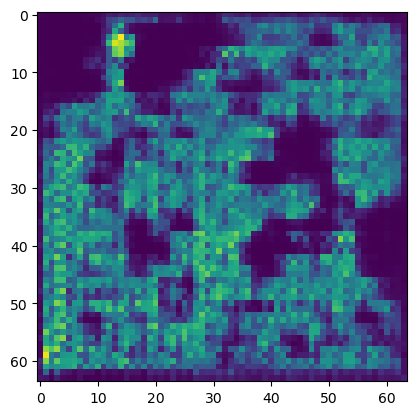

epoch = 671
Gen loss = tf.Tensor(0.26320103, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10013842, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 672
Gen loss = tf.Tensor(0.24574132, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11330139, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 673
Gen loss = tf.Tensor(0.2536327, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10945482, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 674
Gen loss = tf.Tensor(0.2532106, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.108298235, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 675
Gen loss = tf.Tensor(0.264812, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.104408376, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 676
Gen loss = tf.Tensor(0.26505277, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.110565454, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 677
Gen loss = tf.Tensor(0.24718715, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.110380135, sh

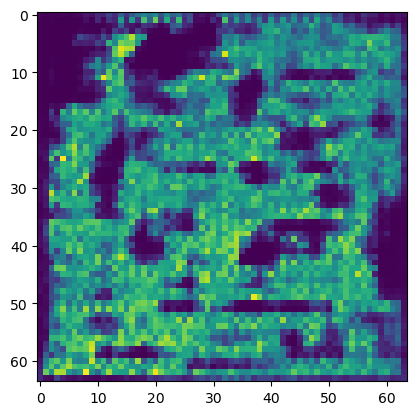

epoch = 681
Gen loss = tf.Tensor(0.24778305, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1119875, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 682
Gen loss = tf.Tensor(0.26048738, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1023221, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 683
Gen loss = tf.Tensor(0.2664496, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11098999, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 684
Gen loss = tf.Tensor(0.24730961, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11754423, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 685
Gen loss = tf.Tensor(0.25094628, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.113107644, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 686
Gen loss = tf.Tensor(0.2545648, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11295122, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 687
Gen loss = tf.Tensor(0.24150805, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.118233085, shap

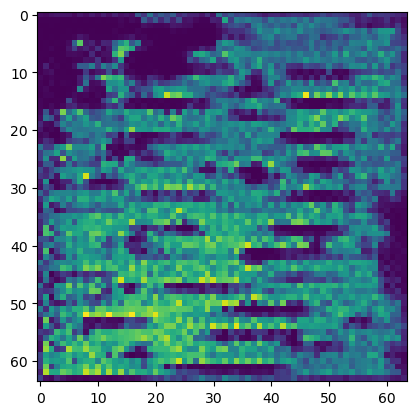

epoch = 691
Gen loss = tf.Tensor(0.2518688, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11112439, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 692
Gen loss = tf.Tensor(0.24027796, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10383467, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 693
Gen loss = tf.Tensor(0.23945116, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.11569015, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 694
Gen loss = tf.Tensor(0.23740576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.114820875, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 695
Gen loss = tf.Tensor(0.24912965, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10700824, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 696
Gen loss = tf.Tensor(0.25329155, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.111056425, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 697
Gen loss = tf.Tensor(0.26798, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09822187, shap

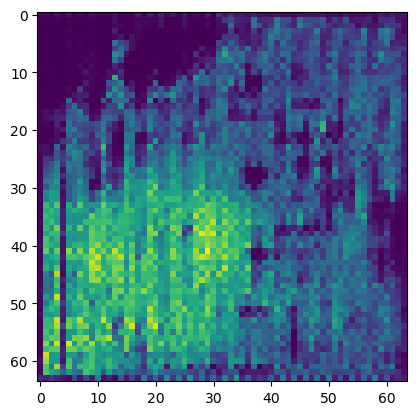

epoch = 701
Gen loss = tf.Tensor(0.25548676, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.106305785, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 702
Gen loss = tf.Tensor(0.2542292, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10531292, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 703
Gen loss = tf.Tensor(0.2738017, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08965284, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 704
Gen loss = tf.Tensor(0.30122995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08694617, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 705
Gen loss = tf.Tensor(0.31574658, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08623406, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 706
Gen loss = tf.Tensor(0.3135995, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08041175, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 707
Gen loss = tf.Tensor(0.36353496, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054182936, sha

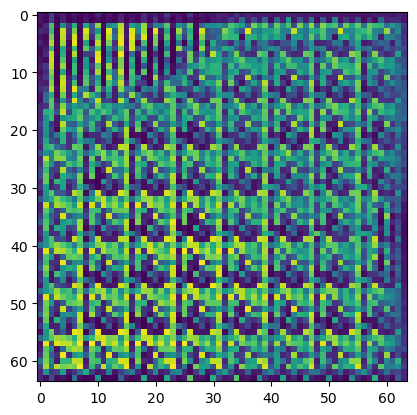

epoch = 711
Gen loss = tf.Tensor(0.2657087, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.1095576, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 712
Gen loss = tf.Tensor(0.32692236, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.09048063, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 713
Gen loss = tf.Tensor(0.3334793, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.061353195, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 714
Gen loss = tf.Tensor(0.3144339, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.069128476, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 715
Gen loss = tf.Tensor(0.3324171, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05847636, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 716
Gen loss = tf.Tensor(0.27918717, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.0795393, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 717
Gen loss = tf.Tensor(0.3294373, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07280745, shape=(

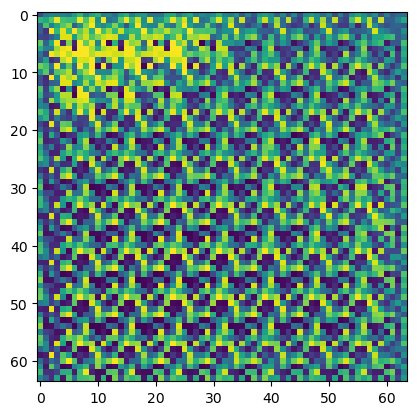

epoch = 721
Gen loss = tf.Tensor(0.35416308, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058342267, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 722
Gen loss = tf.Tensor(0.34147644, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.065300964, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 723
Gen loss = tf.Tensor(0.2683616, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10064273, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 724
Gen loss = tf.Tensor(0.33099616, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.07011471, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 725
Gen loss = tf.Tensor(0.39641798, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04274531, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 726
Gen loss = tf.Tensor(0.3809116, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050241604, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 727
Gen loss = tf.Tensor(0.44768763, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03875914, s

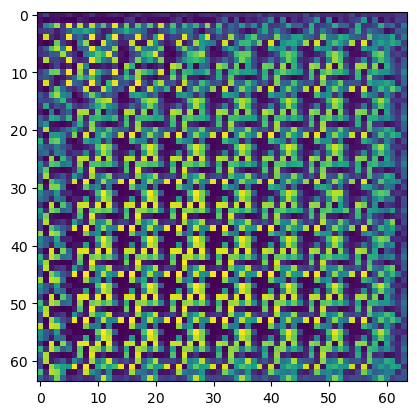

epoch = 731
Gen loss = tf.Tensor(0.38800892, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04064502, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 732
Gen loss = tf.Tensor(0.3429562, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05059722, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 733
Gen loss = tf.Tensor(0.3694218, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.057683963, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 734
Gen loss = tf.Tensor(0.45854446, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.032057915, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 735
Gen loss = tf.Tensor(0.42928073, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.028036691, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 736
Gen loss = tf.Tensor(0.3841672, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042191427, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 737
Gen loss = tf.Tensor(0.36028805, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059602737, 

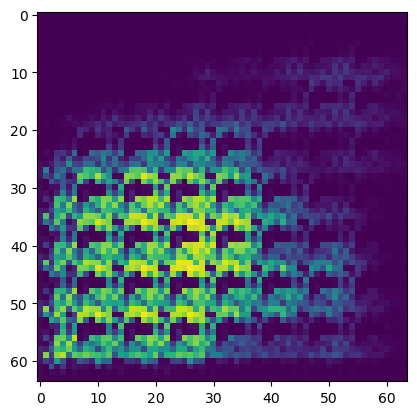

epoch = 741
Gen loss = tf.Tensor(0.40559134, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039360944, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 742
Gen loss = tf.Tensor(0.39756167, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.044443894, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 743
Gen loss = tf.Tensor(0.43716136, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03567381, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 744
Gen loss = tf.Tensor(0.41919196, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03926788, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 745
Gen loss = tf.Tensor(0.43332717, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.040391088, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 746
Gen loss = tf.Tensor(0.378342, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048195038, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 747
Gen loss = tf.Tensor(0.41421905, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.041116532,

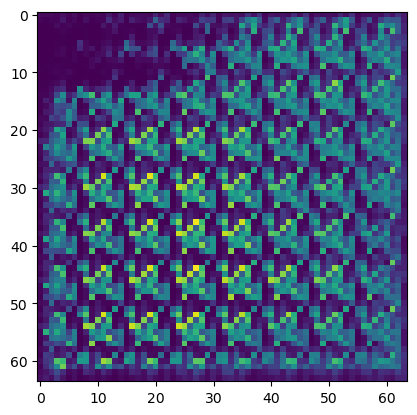

epoch = 751
Gen loss = tf.Tensor(0.37324366, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047359, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 752
Gen loss = tf.Tensor(0.34034726, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.074593, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 753
Gen loss = tf.Tensor(0.40313002, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.042450186, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 754
Gen loss = tf.Tensor(0.32149133, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.060983676, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 755
Gen loss = tf.Tensor(0.31682014, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06789694, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 756
Gen loss = tf.Tensor(0.33206007, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.059312817, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 757
Gen loss = tf.Tensor(0.35156146, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.050913066, sh

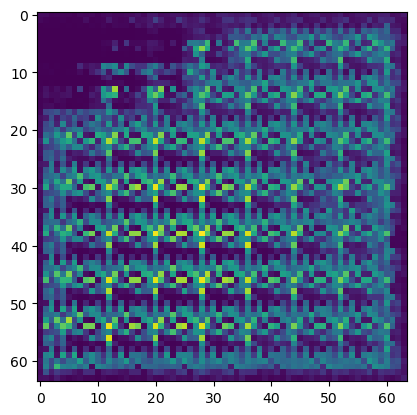

epoch = 761
Gen loss = tf.Tensor(0.39808893, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03707246, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 762
Gen loss = tf.Tensor(0.37510896, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05806536, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 763
Gen loss = tf.Tensor(0.4223247, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.039070368, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 764
Gen loss = tf.Tensor(0.42069122, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.035005894, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 765
Gen loss = tf.Tensor(0.3840644, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05672342, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 766
Gen loss = tf.Tensor(0.5250686, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.019500876, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 767
Gen loss = tf.Tensor(0.46098253, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.027757749, s

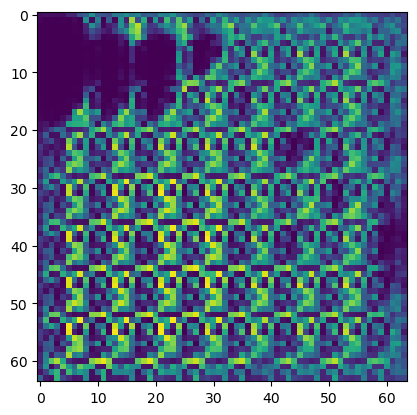

epoch = 771
Gen loss = tf.Tensor(0.36771867, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048707288, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 772
Gen loss = tf.Tensor(0.3985857, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.037049897, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 773
Gen loss = tf.Tensor(0.37124482, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05551299, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 774
Gen loss = tf.Tensor(0.39481506, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.049401682, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 775
Gen loss = tf.Tensor(0.4039494, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.047640737, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 776
Gen loss = tf.Tensor(0.3913478, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04865517, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 777
Gen loss = tf.Tensor(0.37625107, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.065145455, 

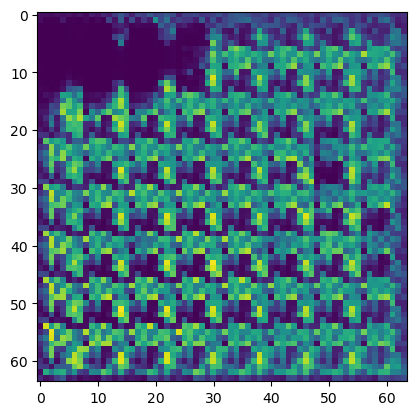

epoch = 781
Gen loss = tf.Tensor(0.40966317, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.03836586, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 782
Gen loss = tf.Tensor(0.3259983, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06348377, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 783
Gen loss = tf.Tensor(0.33731094, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06208852, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 784
Gen loss = tf.Tensor(0.4309405, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.04348776, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 785
Gen loss = tf.Tensor(0.37524748, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.048425063, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 786
Gen loss = tf.Tensor(0.36778393, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05678093, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 787
Gen loss = tf.Tensor(0.36305442, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.058931287, sh

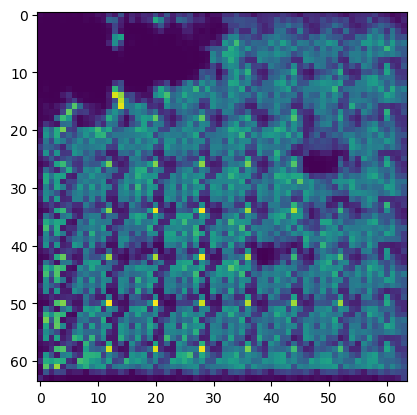

epoch = 791
Gen loss = tf.Tensor(0.27890116, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.10319328, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 792
Gen loss = tf.Tensor(0.3975238, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.05029354, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 793
Gen loss = tf.Tensor(0.36004576, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.054908972, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 794
Gen loss = tf.Tensor(0.2957817, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08413815, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 795
Gen loss = tf.Tensor(0.2992746, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.08380575, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 796
Gen loss = tf.Tensor(0.3327959, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.06899076, shape=(), dtype=float32)
Disc accuracy = 0.0
epoch = 797
Gen loss = tf.Tensor(0.32829627, shape=(), dtype=float32)
Disc loss = tf.Tensor(0.077222265, shap

In [57]:

gen_losses, disc_losses, generated_map, disc_accuracies = train(training_data, N_EPOCHS)


Denormalize, save and display generated map output

(64, 64)


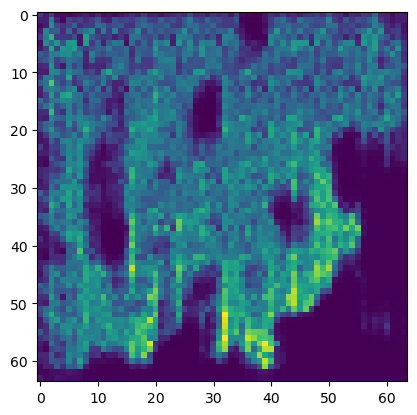

In [58]:
# denormalise generated map

generated_map *= 255

generated_map = generated_map.numpy()

generated_map = np.reshape(generated_map, (64,64))

generated_map = np.round(generated_map,0)
print(generated_map.shape)

#write generated map to csv


np.savetxt('generated_map.csv', generated_map, delimiter=',', fmt='%i')

generated_map = generated_map.tolist()


plt.imshow(generated_map)

# Graphs:

Losses

Text(0.5, 0, 'Epoch')

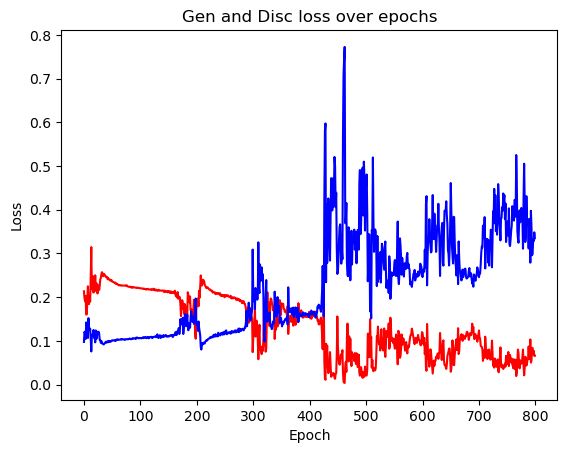

In [59]:
epoch_list = [i for i in range(0,N_EPOCHS)]


plt.plot(epoch_list, disc_losses,  'r-')
plt.plot(epoch_list, gen_losses, 'b-')
plt.title('Gen and Disc loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Discriminator Accuracy

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12800,) + inhomogeneous part.

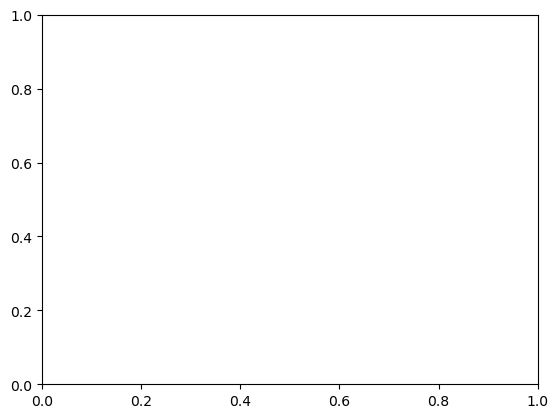

In [60]:
plt.plot(epoch_list, disc_accuracies,  'r-')

plt.title('Disc accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')